# EDA which makes sense ⭐️⭐️⭐️⭐️⭐️

This notebook shows what kind of insight an EDA should give and how this insight is applied in creating a model and for correctly cross-validating it.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from colorama import Fore, Back, Style
import scipy.stats

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

np.set_printoptions(linewidth=150)


# Reading the data

The train file contains 26570 rows and the test file 20775 rows. 

**Insight:** The public leaderboard is based on a quarter of the test file, i.e. only 5000 rows. We have to make sure that we don't overfit to the public leaderboard. We should trust our cross-validation (which is based on 26570 rows) much more than the public leaderboard.

In [2]:
train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv',
                    index_col='id')
test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv',
                    index_col='id')
display(train)
display(test)
both = pd.concat([train[test.columns], test])


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,E,158.95,material_7,material_6,6,9,6,16,4,16.301,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,E,146.02,material_7,material_6,6,9,10,12,8,17.543,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,E,115.62,material_7,material_6,6,9,1,10,1,15.670,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,I,144.74,material_7,material_5,9,5,0,4,9,18.465,...,18.573,11.691,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466
47341,I,74.53,material_7,material_5,9,5,4,8,7,18.900,...,17.917,10.980,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249
47342,I,67.73,material_7,material_5,9,5,10,11,2,18.656,...,19.630,10.436,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349


# The target column

Of the 26570 products tested, 79 % are good and 21 % fail.

**Insight:** This looks like a slightly imbalanced classification. It might be good to stratify the train-test splits.

In [3]:
print(train.failure.value_counts() / len(train))

0    0.787392
1    0.212608
Name: failure, dtype: float64


# The float columns

The data have 16 float columns. All columns have missing values (up to 10 % of the column).

**Insight:** We'll need to impute the missing values (unless we use a classifier which deals with missing values automatically). The simplest solution is filling the missing values with the column's mean, but this simple solution won't win the competition. A more sophisticated solution might use the imputers from [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) or even some customized imputation scheme.



In [4]:
float_cols = [f for f in train.columns if train[f].dtype == float]
pd.concat([train[float_cols].isna().sum().rename('missing values in train'),
           test[float_cols].isna().sum().rename('missing values in test')],
          axis=1)

,missing values in train,missing values in test
loading,250,223
measurement_3,381,329
measurement_4,538,409
measurement_5,676,508
measurement_6,796,624
measurement_7,937,720
measurement_8,1048,846
measurement_9,1227,904
measurement_10,1300,1067
measurement_11,1468,1136


More than half the rows have at least one missing value:

In [5]:
print(f"{both[float_cols].isna().any(axis=1).sum() / len(both):.0%}")

54%


**Insight:** With that many missing values, good value imputation will be the key for winning the competition.

Let's look at the distribution of the float features. We plot the train and test histograms in the same diagram - train is blue, test is orange.

We see that the first feature, loading, has a skewed distribution, perhaps log-normal; the other features are normally distributed. The first eight features have the same distribution in train and test; from measurement_10 onwards the distributions differ slightly.

In the same diagrams, we show the failure probabilities with magenta dots. The top left diagram shows that higher loadings imply a higher failure probability. The bottom right diagram shows that measurement_17 is positively correlated to the target as well. All other float features seem to be uncorrelated to the failure probability (the failure probability is 21 % independent of the feature value).

**Insight:**
- Maybe we can apply a log-transformation to the loading to make the distribution more symmetric.
- As the measurements are uncorrelated to the failure probability, they are useless for a linear classifier. We need more complex classifiers which can deal with feature interactions (decision trees, neural networks, ...) - or good feature engineering.

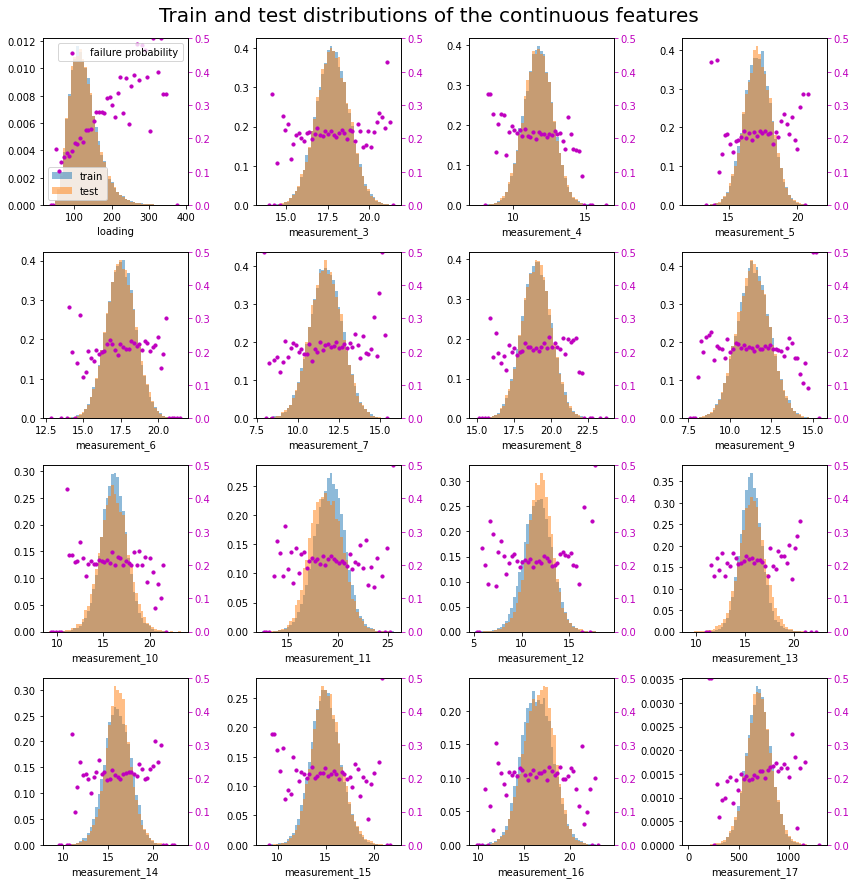

In [6]:
_, axs = plt.subplots(4, 4, figsize=(12,12))
for f, ax in zip(float_cols, axs.ravel()):
    mi = min(train[f].min(), test[f].min())
    ma = max(train[f].max(), test[f].max())
    bins = np.linspace(mi, ma, 50)
    ax.hist(train[f], bins=bins, alpha=0.5, density=True, label='train')
    ax.hist(test[f], bins=bins, alpha=0.5, density=True, label='test')
    ax.set_xlabel(f)
    if ax == axs[0, 0]: ax.legend(loc='lower left')
        
    ax2 = ax.twinx()
    total, _ = np.histogram(train[f], bins=bins)
    failures, _ = np.histogram(train[f][train.failure == 1], bins=bins)
    with warnings.catch_warnings(): # ignore divide by zero for empty bins
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        ax2.scatter((bins[1:] + bins[:-1]) / 2, failures / total,
                    color='m', s=10, label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the continuous features', fontsize=20, y=1.02)
plt.show()

Did it occur to you that a missing measurement might be an early indicator of product failure? Maybe the cause of a product failure triggers the failure of a measurement device. How can we test this idea? Obviously we have to calculate the conditional product failure rate given the measurement is missing E\[product fails | measurement is missing\] and compare it to the unconditional product failure rate, which is 0.212608.

Of course, the deviations will be small and we should test them for significance against a null hypothesis which says that the failure count is binomially distributed with p = 0.212608. For simplicity, we can approximate the binomial distribution by a normal distribution, calculate the [z-score](https://en.wikipedia.org/wiki/Standard_score) and the [p-value](https://en.wikipedia.org/wiki/P-value):


feature           fail   miss   failure rate       z    p-value
loading         :   44 /  250 = 0.176          -1.41      0.157
measurement_3   :   61 /  381 = 0.160          -2.50      0.012
measurement_4   :  128 /  538 = 0.238           1.43      0.151
measurement_5   :  172 /  676 = 0.254           2.66      0.008
measurement_6   :  171 /  796 = 0.215           0.15      0.879
measurement_7   :  197 /  937 = 0.210          -0.18      0.860
measurement_8   :  218 / 1048 = 0.208          -0.36      0.716
measurement_9   :  283 / 1227 = 0.231           1.54      0.123
measurement_10  :  277 / 1300 = 0.213           0.04      0.967
measurement_11  :  311 / 1468 = 0.212          -0.07      0.944
measurement_12  :  356 / 1601 = 0.222           0.95      0.340
measurement_13  :  373 / 1774 = 0.210          -0.24      0.809
measurement_14  :  413 / 1874 = 0.220           0.82      0.411
measurement_15  :  430 / 2009 = 0.214           0.16      0.876
measurement_16  :  436 / 2110 = 0.207   

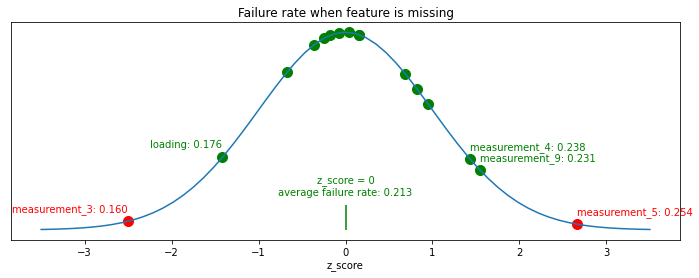

In [7]:
# Start by plotting the bell curve
plt.figure(figsize=(12, 4))
z_ticks = np.linspace(-3.5, 3.5, 61)
pdf = scipy.stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)

# Calculate the conditional failure rate for every missing feature
# Print the values and plot them
print('feature           fail   miss   failure rate       z    p-value')
for f in train.columns:
    if train[f].isna().sum() > 0:
        total = train[f].isna().sum()
        fail = train[train[f].isna()].failure.sum()
        z = (fail / total - 0.212608) / (np.sqrt(0.212608 * (1-0.212608)) / np.sqrt(total))
        plt.scatter([z], [scipy.stats.norm.pdf(z)], c='r' if abs(z) > 2 else 'g', s=100)
        print(f"{f:15} : {fail:4} / {total:4} = {fail/total:.3f}          {z:5.2f}      {2*scipy.stats.norm.cdf(-abs(z)):.3f}")
        if abs(z) > 1: plt.annotate(f"{f}: {fail / total:.3f}",
                                    (z, scipy.stats.norm.pdf(z)),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='left' if z > 0 else 'right',
                                    color='r' if abs(z) > 2 else 'g')
            
# Annotage the center (z=0)
plt.vlines([0], 0, 0.05, color='g')
plt.annotate(f"z_score = 0\naverage failure rate: {0.212608:.3f}",
                                    (0, 0.05),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='center',
                                    color='g')
plt.title('Failure rate when feature is missing')
plt.yticks([])
plt.xlabel('z_score')
plt.show()

- When measurement_3 is missing, the failure rate is 0.160 (much lower than average).
- When measurement_5 is missing, the failure rate is 0.254 (much higher than average).

With abs(z) > 2.5 and pvalue < 2 %, the conditional failure rates of missing measurement_3 and missing measurement_5 deviate significantly from the average failure rate and we can use the features m_3_missing and m_5_missing in our models:

```
X['m_3_missing'] = X.measurement_3.isna()
X['m_5_missing'] = X.measurement_5.isna()
```

# The integer columns

There are five integer columns. We are lucky: the columns are complete, without missing values. Two of the columns are called *attribute* and three *measurement*.

In [8]:
int_cols = [f for f in train.columns if train[f].dtype == int and f != 'failure']
pd.concat([train[int_cols].isna().sum().rename('missing values in train'),
           test[int_cols].isna().sum().rename('missing values in test')],
          axis=1)

,missing values in train,missing values in test
attribute_2,0,0
attribute_3,0,0
measurement_0,0,0
measurement_1,0,0
measurement_2,0,0


Let's plot the distributions of the five integer features for train and test:

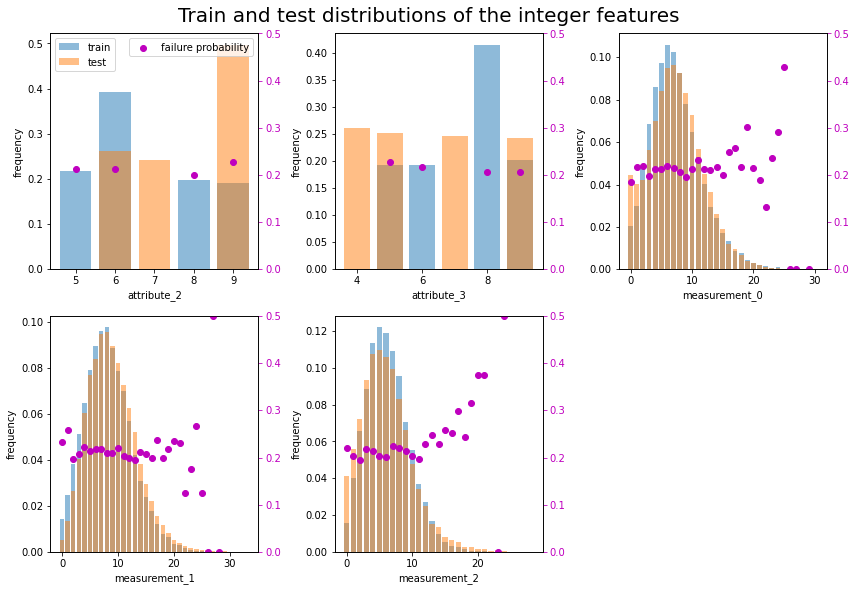

In [9]:
_, axs = plt.subplots(2, 3, figsize=(12, 8))
for f, ax in zip(int_cols, axs.ravel()):
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    ax.bar(temp1.index, temp1['size'] / len(train), alpha=0.5, label='train')
    temp2 = test[f].value_counts()
    ax.bar(temp2.index, temp2 / len(test), alpha=0.5, label='test')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')

    ax2 = ax.twinx()
    ax2.scatter(temp1.index, temp1['mean'],
                color='m', label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')

axs[0, 0].legend()
axs[1, 2].axis('off')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the integer features', fontsize=20, y=1.02)
plt.show()
del temp1, temp2

We see that attribute_2 has two values (5 and 8) which occur only in the training data, and another value (7) occurs only in the test data. attribute_3 is similar.
Measurement_2 has positive correlation with the target, at least for values > 10.

**Insight**:
- The two attributes could be categorical features. Perhaps we should one-hot encode them and make sure that our classifier can deal with the values which occur only in test.
- As measurement_2 is correlated to the target only for values above 10, linear classifiers will profit if we clip all values below 10.
- Again, most features are uncorrelated to the failure probability. If a linear classifier wins this competition, it will win only with very good feature engineering.


# The string columns

Three columns contain strings. They have no missing values.

In [10]:
string_cols = [f for f in train.columns if train[f].dtype == object]
pd.concat([train[string_cols].isna().sum().rename('missing values in train'),
           test[string_cols].isna().sum().rename('missing values in test')],
          axis=1)

,missing values in train,missing values in test
product_code,0,0
attribute_0,0,0
attribute_1,0,0


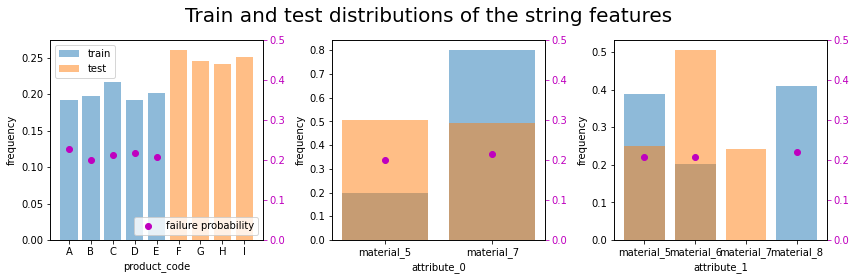

In [11]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
for f, ax in zip(string_cols, axs.ravel()):
    temp1 = train[f].value_counts(dropna=False, normalize=True)
    temp2 = test[f].value_counts(dropna=False, normalize=True)
    values = sorted(set(temp1.index).union(temp2.index))
    temp1 = temp1.reindex(values)
    temp2 = temp2.reindex(values)
    ax.bar(range(len(values)), temp1, alpha=0.5, label='train')
    ax.bar(range(len(values)), temp2, alpha=0.5, label='test')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')
    ax.set_xticks(range(len(values)), values)
    
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    temp1 = temp1.reindex(values)
    ax2 = ax.twinx()
    ax2.scatter(range(len(values)), temp1['mean'],
                color='m', label='failure probability')
    ax2.tick_params(axis='y', colors='m')
    ax2.set_ylim(0, 0.5)
    if ax == axs[0]: ax2.legend(loc='lower right')

axs[0].legend()
plt.suptitle('Train and test distributions of the string features', fontsize=20, y=0.96)
plt.tight_layout(w_pad=1)
plt.show()
del temp1, temp2   


**Insight:**
- The product codes of train and test are disjoint: A through E are the training products, F through I are the test products. We want to create a classifier which predicts correct probabilities for previously unseen products. To validate such a classifier, we have to simulate this situation by splitting the data so that the validation set contains other products than the training set. The correct method here is a five-fold cross-validation where every fold uses four products for training and the fifth product for validation ([GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html)). Forget what I wrote about imbalanced classes and stratified folds above - getting the product codes right is much more important!
- Feature engineering: We can use the product codes for feature engineering by adding aggregate statistics of the measurements, grouped by product code, as new features.
- Attribute_0 and attribute_1 are categorical features which should be one-hot encoded.

# Product codes and attributes

@takanashihumbert has [discovered a dependency among the attributes](https://www.kaggle.com/code/takanashihumbert/interesting-patterns-found-in-category-features): All four attributes are completely determined by the product code. If we wanted to store the data in a relational database, we'd normalize it by storing the product attributes in a separate table.

In [12]:
both[string_cols + ['attribute_2', 'attribute_3']].drop_duplicates().set_index('product_code')

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


# Baseline model with cross-validation

In the following, we'll see how to correctly implement preprocessing and cross-validation for a simple model. You can play around with the hyperparameters - I haven't really optimized them yet.

The code contains a choice of three classifiers: RandomForestClassifier, ExtraTreesClassifier and LogisticRegression. The saved version of the notebook uses LogisticRegression and prints the weights which the classifier optimizes.

When I did this experiment for the first time, I saw that most regression coefficients were near zero, which means that the corresponding features are noise. To verify this thought, I configured the classifier for a l1 penalty. The l1 penalty tries to select as few features as possible for the model.

The pipeline consists of the following steps:
1. Split train and validation ([GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) on product_code)
2. One-hot encode attribute_0 and attribute_1
3. Impute the missing values ([KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html))
4. Clip measurement_2
5. Scale the data (StandardScaler)
6. Logistic regression with l1 penalty
7. Evaluate feature importances (regression coefficients)


Fold 0: auc = 0.58827
Fold 1: auc = 0.58291
Fold 2: auc = 0.59105
Fold 3: auc = 0.59753
Fold 4: auc = 0.59675
Average auc = 0.59130


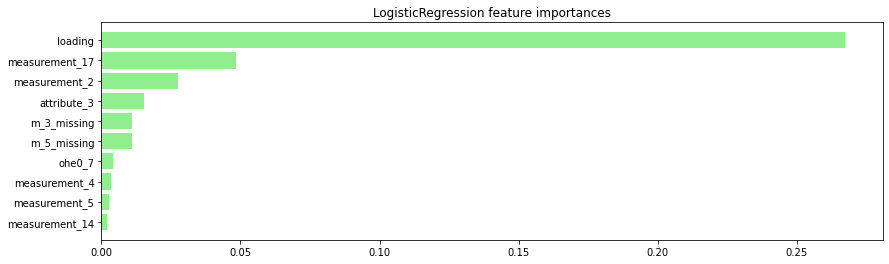

In [13]:
auc_list = []
test_pred_list = []
importance_list = []
kf = GroupKFold(n_splits=5) # must be 5 because of the 5 product codes
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.failure, train.product_code)):
    X_tr = train.iloc[idx_tr][test.columns]
    X_va = train.iloc[idx_va][test.columns]
    X_te = test.copy()
    y_tr = train.iloc[idx_tr].failure
    y_va = train.iloc[idx_va].failure

    # We one-hot encode attribute_0 and attribute_1
    ohe_attributes = ['attribute_0', 'attribute_1']
    ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8']
    ohe = OneHotEncoder(categories=[['material_5', 'material_7'],
                                    ['material_5', 'material_6', 'material_8']],
                        drop='first', sparse=False, handle_unknown='ignore')
    ohe.fit(X_tr[ohe_attributes])
    for df in [X_tr, X_va, X_te]:
        with warnings.catch_warnings(): # ignore "Found unknown categories"
            warnings.filterwarnings('ignore', category=UserWarning)
            df[ohe_output] = ohe.transform(df[ohe_attributes])
        df.drop(columns=ohe_attributes, inplace=True)

    # We add the indicators for missing values
    for df in [X_tr, X_va, X_te]:
        df['m_3_missing'] = df.measurement_3.isna()
        df['m_5_missing'] = df.measurement_5.isna()

    # We fill the missing values
    features = [f for f in X_tr.columns if f == 'loading' or f.startswith('measurement')]
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X_tr[features])
    for df in [X_tr, X_va, X_te]:
        df[features] = imputer.transform(df[features])

    # The EDA diagram of measurement 2 shows that the feature is correlated
    # to the target only for values above 10. For this reason, we clip
    # all values below 11.
    for df in [X_tr, X_va, X_te]:
        df['measurement_2'] = df['measurement_2'].clip(11, None)

    # We fit a model
    features2 = [f for f in X_tr.columns if f != 'product_code']
    #model = RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=100, n_jobs=-1, random_state=1)
    #model = ExtraTreesClassifier(n_estimators=100, max_depth=8, min_samples_leaf=100, max_features=5, n_jobs=-1, random_state=1)
    model = make_pipeline(StandardScaler(), 
                          LogisticRegression(penalty='l1', C=0.01,
                                             solver='liblinear', random_state=1))
    model.fit(X_tr[features2], y_tr)
    importance_list.append(model.named_steps['logisticregression'].coef_.ravel())

    # We validate the model
    y_va_pred = model.predict_proba(X_va[features2])[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)

    test_pred_list.append(model.predict_proba(X_te[features2])[:,1])

# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {sum(auc_list) / len(auc_list):.5f}{Style.RESET_ALL}")

# Show feature importances
importance_df = pd.DataFrame(np.array(importance_list).T, index=features2)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = features2
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
plt.figure(figsize=(14, 4))
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

# Manual feature selection

If you look at the logistic regression coefficients above (the green bar chart), you'll see that the first coefficient is 0.27 or 0.28 and all other coefficients are near zero. Loading, the first feature, is the most important feature. A few manual tests show that selecting the five features with the highest logistic regression weights ('loading', 'attribute_3', 'measurement_2', 'measurement_4', 'measurement_17') increases the cv score to 0.59256.

At this point I suggest that you scroll back to the diagrams which show the correlation between the features and the target (the magenta scatterplots). Can you see why these five features get selected?

If you scroll back even more (up to the missing value count), you'll see that measurement_17 (second highest importance) is the feature with the most missing values. 

In [14]:
# Same code as in the cell above except for the assignment to features2
auc_list = []
test_pred_list = []
kf = GroupKFold(n_splits=5) # must be 5 because of the 5 product codes
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.failure, train.product_code)):
    X_tr = train.iloc[idx_tr][test.columns]
    X_va = train.iloc[idx_va][test.columns]
    X_te = test.copy()
    y_tr = train.iloc[idx_tr].failure
    y_va = train.iloc[idx_va].failure
    
    # We one-hot encode attribute_0 and attribute_1
    ohe_attributes = ['attribute_0', 'attribute_1']
    ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8']
    ohe = OneHotEncoder(categories=[['material_5', 'material_7'],
                                    ['material_5', 'material_6', 'material_8']],
                        drop='first', sparse=False, handle_unknown='ignore')
    ohe.fit(X_tr[ohe_attributes])
    for df in [X_tr, X_va, X_te]:
        with warnings.catch_warnings(): # ignore "Found unknown categories"
            warnings.filterwarnings('ignore', category=UserWarning)
            df[ohe_output] = ohe.transform(df[ohe_attributes])
        df.drop(columns=ohe_attributes, inplace=True)

    # We add the indicators for missing values
    for df in [X_tr, X_va, X_te]:
        df['m_3_missing'] = df.measurement_3.isna()
        df['m_5_missing'] = df.measurement_5.isna()

    # We fill the missing values
    features = [f for f in X_tr.columns if f == 'loading' or f.startswith('measurement')]
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X_tr[features])
    for df in [X_tr, X_va, X_te]:
        df[features] = imputer.transform(df[features])
                
    # The EDA diagram of measurement 2 shows that the feature is correlated
    # to the target only for values above 10. For this reason, we clip
    # all values below 11.
    for df in [X_tr, X_va, X_te]:
        df['measurement_2'] = df['measurement_2'].clip(11, None)
    
    # We fit a model using only the most important features
    features2 = ['loading', 'attribute_3', 'measurement_2', 'measurement_4', 'measurement_17', 'm_3_missing', 'm_5_missing']
    #model = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=100, n_jobs=-1, random_state=1)
    #model = ExtraTreesClassifier(n_estimators=1000, max_depth=9, min_samples_leaf=100, n_jobs=-1, random_state=1)
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_tr[features2], y_tr)
    with np.printoptions(linewidth=150, precision=2, suppress=True):
        print(model.named_steps['logisticregression'].coef_)
    
    # We validate the model
    y_va_pred = model.predict_proba(X_va[features2])[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)

    test_pred_list.append(model.predict_proba(X_te[features2])[:,1])
print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {sum(auc_list) / len(auc_list):.5f}{Style.RESET_ALL}")


[[ 0.3  -0.06  0.06 -0.03  0.09 -0.04  0.03]]
Fold 0: auc = 0.59041
[[ 0.3  -0.05  0.06 -0.02  0.09 -0.02  0.05]]
Fold 1: auc = 0.58503
[[ 0.29 -0.04  0.03 -0.04  0.08 -0.06  0.04]]
Fold 2: auc = 0.59351
[[ 0.29 -0.05  0.05 -0.05  0.08 -0.06  0.03]]
Fold 3: auc = 0.59812
[[ 0.29 -0.02  0.06 -0.03  0.1  -0.04  0.04]]
Fold 4: auc = 0.59641
Average auc = 0.59270


If you want to learn more about feature importance in linear models, [read here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

# ROC curve

To get a feeling for the auc metric, we plot the roc curve. The light red area under the curve corresponds to the AUC score.

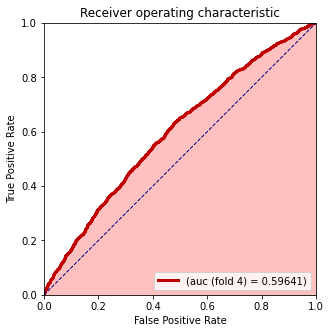

In [15]:
plt.figure(figsize=(5, 5))
fpr, tpr, _ = roc_curve(y_va, y_va_pred)
plt.plot(fpr, tpr, color='#c00000', lw=3, label=f"(auc (fold 4) = {roc_auc_score(y_va, y_va_pred):.5f})") # curve
plt.fill_between(fpr, tpr, color='#ffc0c0') # area under the curve
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--") # diagonal
plt.gca().set_aspect('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()


# Submission

We finally create a submission file. I won't submit it myself because I trust the cv scores more than the public leaderboard.

In [16]:
submission = pd.DataFrame({'id': test.index,
                           'failure': sum(test_pred_list)/len(test_pred_list)})
submission.to_csv('submission_four_features.csv', index=False)
submission

,id,failure
0,26570,0.213512
1,26571,0.185199
2,26572,0.205256
3,26573,0.196232
4,26574,0.354649
...,...,...
20770,47340,0.234280
20771,47341,0.156401
20772,47342,0.153990
20773,47343,0.223727


To get a feeling for the predicted probabilities and as a sanity check, we plot histograms of the validation and test predictions. If the two histograms deviate from each other, this could indicate a bug in the model.

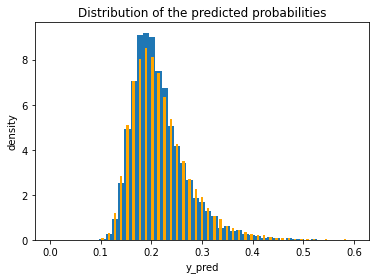

In [17]:
plt.hist(y_va_pred, bins=np.linspace(0, 0.6, 50), density=True, label='validation')
plt.hist(submission.failure, bins=np.linspace(0, 0.6, 50), density=True,
         color='orange', rwidth=0.4, label='test')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('Distribution of the predicted probabilities')
plt.show()

# Feature correlations per product

Let's look at the correlations of the continuous features for every product. Green matrix entries are positive correlations, red ones are negative. In most browsers, you can right-click on the matrices to zoom in.

We see:
1. Most correlations are zero.
2. loading isn't correlated with any measurement.
3. The correlations matrices of the products differ from each other.
4. Measurement_17 (the row with many green entries) seems to depend on measurement_3 to measurement_9.
5. There are some correlations among measurement_10 to measurement_16.
6. There are some correlations among the integer features measurement_0 to measurement_2.

**Insight:** People like to show correlation matrices in EDAs, but they are often useless. In this competition, however, the correlations may become important: they will help impute missing values well, in particular for measurement_17.

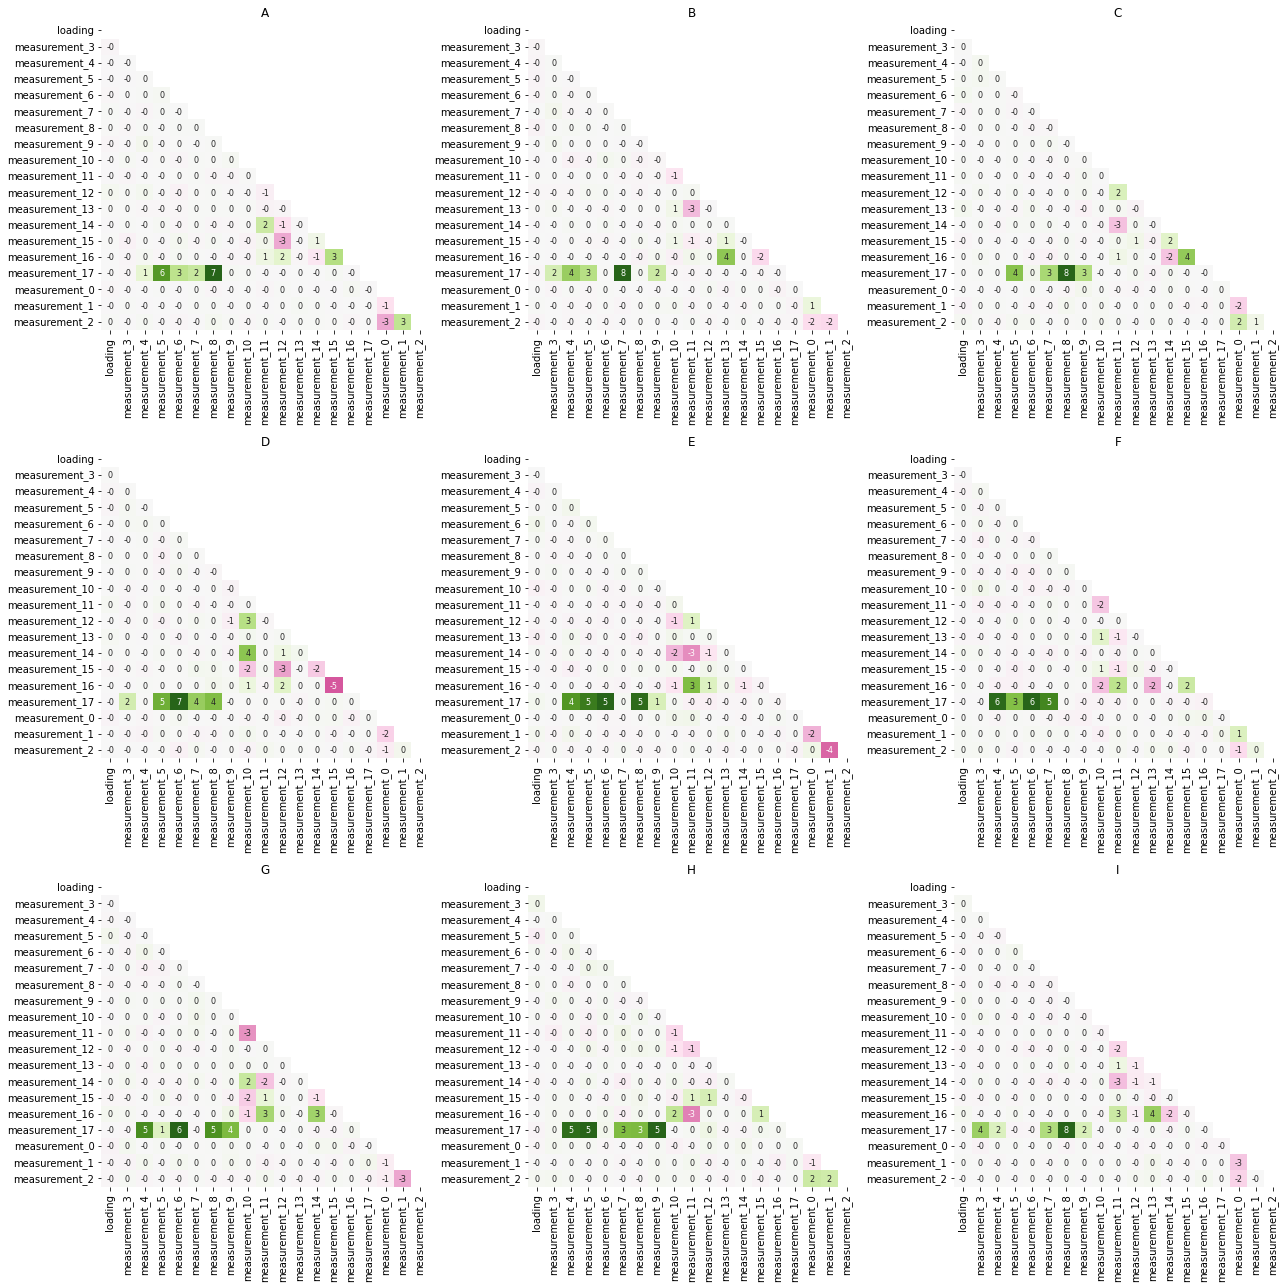

In [18]:
_, axs = plt.subplots(3, 3, figsize=(18, 18))
for product, ax in zip(np.unique(both.product_code), axs.ravel()):
    corr = both[float_cols + ['measurement_0', 'measurement_1', 'measurement_2']][both.product_code == product].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr*10, mask=mask, linewidth=0.0, fmt='.0f', 
                annot=True, annot_kws={'size': 8}, 
                cmap='PiYG', center=0, ax=ax, cbar=False)
    ax.set_title(product)
plt.tight_layout(w_pad=0.5)
plt.show()

# Per-product distributions of the features

One can ask how the feature distributions depend on the product codes. The diagram shows that the first eight features are independent of the product code. Measurement_10 through measurement_17 and measurement_0 through measurement_2 depend on the product.

**Insight:** When we impute the missing values for these features, the imputed value should depend on the product code. SimpleImputer and KNNImputer do not take this dependence into account.

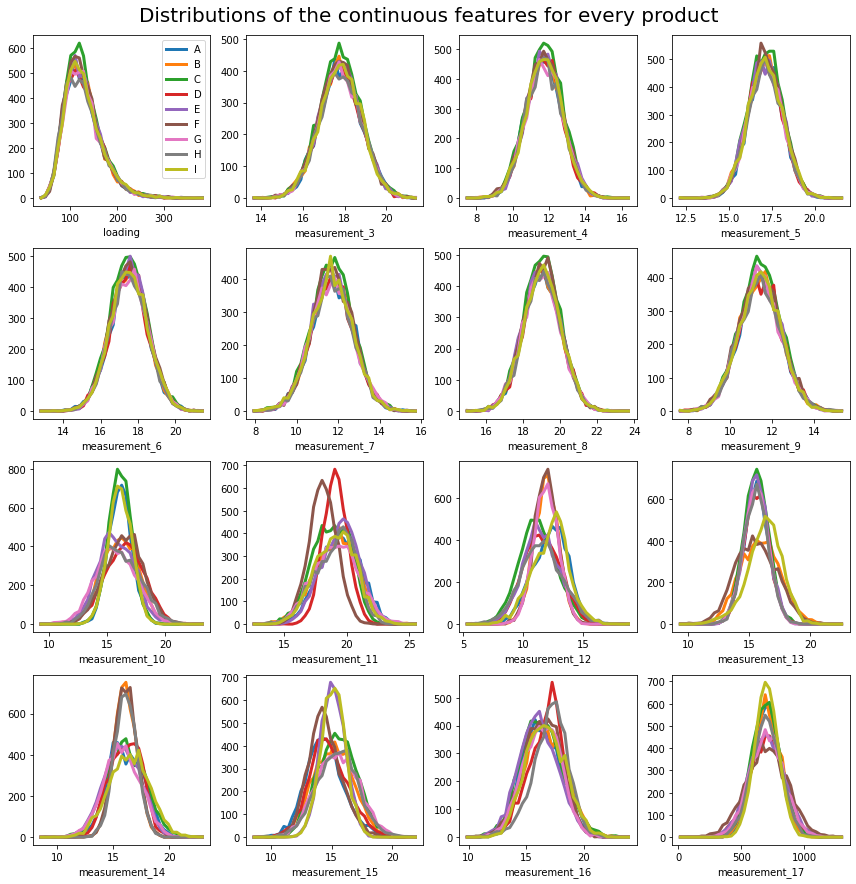

In [19]:
_, axs = plt.subplots(4, 4, figsize=(12,12))
for f, ax in zip(float_cols, axs.ravel()):
    mi = both[f].min()
    ma = both[f].max()
    bins = np.linspace(mi, ma, 40)
    for product in np.unique(both.product_code):
        h, edges = np.histogram(both[f][both.product_code == product], bins=bins)
        ax.plot((edges[:-1] + edges[1:]) / 2, h, label=product, lw=3)
    ax.set_xlabel(f)
    if ax == axs[0, 0]: ax.legend(loc='upper right')
plt.tight_layout(w_pad=1)
plt.suptitle('Distributions of the continuous features for every product', fontsize=20, y=1.02)
plt.show()


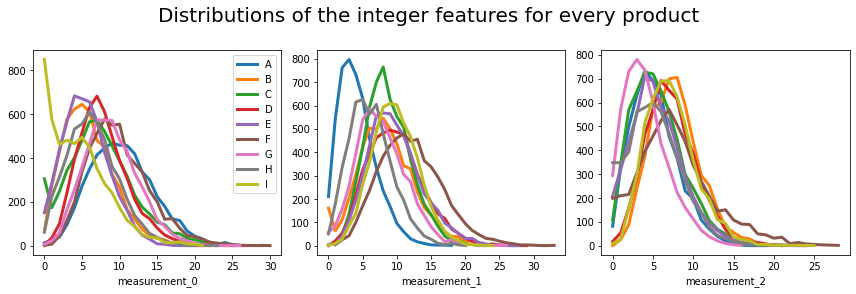

In [20]:
prop_cycle = plt.rcParams['axes.prop_cycle']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()
for(ax, f) in zip(axs, ['measurement_0', 'measurement_1', 'measurement_2']):
    for i, product in enumerate(np.unique(both.product_code)):
        uv, uc = np.unique(both[f][both.product_code == product], return_counts=True)
        ax.plot(uv, uc, alpha=1, color=prop_cycle.by_key()['color'][i % 10],
                lw=3, label=product)
    ax.set_xlabel(f)
    if ax == axs[0]: ax.legend()
plt.suptitle('Distributions of the integer features for every product', y=1.01, fontsize=20)
plt.tight_layout(w_pad=1)
plt.show()